In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
sample_sub = pd.read_csv('/home/ghk829/zillow_data/sample_submission.csv')

In [7]:
sample_sub.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [2]:
df_1=pd.read_csv('/home/ghk829/zillow_data/train_2016_v2.csv')

In [3]:
df_2=pd.read_csv('/home/ghk829/zillow_data/properties_2016.csv')

/home/ghk829/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
for c in df_2.dtypes[df_2.dtypes == 'float64'].index.values:
	df_2[c].fillna(df_2[c].median(skipna=True), inplace = True)
#fill -1 for categorical columns
for c in df_2.columns:
	df_2[c]=df_2[c].fillna(-1)
	if df_2[c].dtype == object:
		lbl = LabelEncoder()
		lbl.fit(list(df_2[c].values))
		df_2[c] = lbl.transform(list(df_2[c].values))

In [63]:
col_list = list(df_2.columns)
x_names=[]
for index,value in enumerate(df_2.columns):
    if index in range(0,col_list.index('finishedsquarefeet13'))+range(col_list.index('finishedsquarefeet13')+1,len(df_2.columns)-1):
        x_names.append(value)

In [15]:
train_df = pd.merge(df_1, df_2, on='parcelid', how='left')

In [6]:
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'transactiondate']+cat_cols, axis=1)

In [7]:
import h2o

In [8]:
h2o.init(nthreads=-1,max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ghk829/miniconda2/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpq87Ya3
  JVM stdout: /tmp/tmpq87Ya3/h2o_ghk829_started_from_python.out
  JVM stderr: /tmp/tmpq87Ya3/h2o_ghk829_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,3 months and 18 days !!!
H2O cluster name:,H2O_from_python_ghk829_z8wfg2
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [9]:
df=h2o.H2OFrame(python_obj=train_df.to_dict("list"))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [10]:
splits = df.split_frame(ratios=[0.7, 0.15]) 

In [11]:
train = splits[0]
valid = splits[1]
test = splits[2]

In [12]:
len(df.col_names)

53

In [14]:
print df.col_names.index('logerror')

2


In [15]:
y_names= df.col_names[2]
x_names = df.col_names[0:2]

In [16]:
for index,value in enumerate(df.col_names[3:53]):
    x_names.append(value)

In [17]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [18]:
fit1 = H2ORandomForestEstimator(model_id = 'fit1')

In [19]:
fit1.train(x=x_names, y=y_names, training_frame=train, validation_frame=valid)

drf Model Build progress: |████████████████████████████████████████████████| 100%


In [20]:
perp1=fit1.model_performance(test)

In [27]:
print perp1


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.0234377123912
RMSE: 0.153093802589
MAE: 0.0707116844003
RMSLE: NaN
Mean Residual Deviance: 0.0234377123912



In [28]:
import matplotlib.pyplot as plt

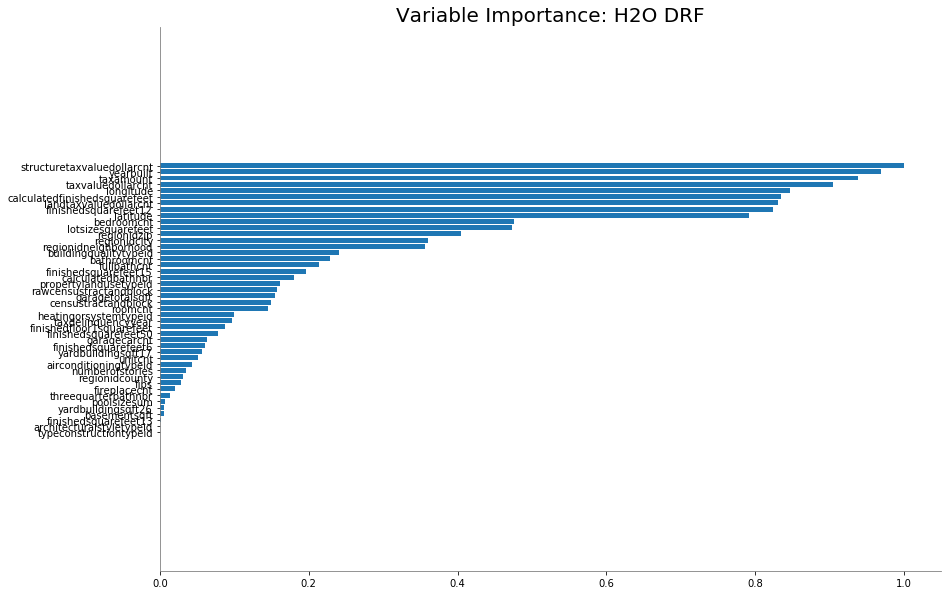

In [29]:
fit1.varimp_plot()